In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import logging
import re
import time
import psana
from scipy.optimize import curve_fit
from argparse import ArgumentParser
import json
import os
import sys
from bokeh.plotting import figure, show, output_file
from bokeh.models import Span, Legend, LegendItem, ColorBar, LinearColorMapper
from bokeh.io import output_notebook, grid_plot
import panel as pn
from scipy.stats import gaussian_kde
output_notebook()

Loading BokehJS ...

In [3]:
def get_r_masks(shape, bins=100):
    """Function to generate radial masks for pixels to include in azav"""
    center = (shape[1] / 2, shape[0] / 2)
    x, y = np.meshgrid(np.arange(shape[1]) - center[0], np.arange(shape[0]) - center[1])
    R = np.sqrt(x**2 + y**2)
    max_R = np.max(R)
    min_R = np.min(R)
    bin_size = (max_R - min_R) / bins
    radii = np.arange(1, max_R, bin_size)
    masks = []
    for i in radii:
        mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
        masks.append(mask)

    return masks
bins=100
exp_run = 'exp=cxilv9518:run=148'
info = re.split('=|:', exp_run)
    #print('inof ', info)
exp = info[1]
hutch = exp[:3]
exp_dir = ''.join(['/reg/d/psdm/', hutch, '/', exp, '/xtc/'])
dsname = ''.join([exp_run, ':smd:', 'dir=', exp_dir])
ds = psana.DataSource(dsname)
detector = psana.Detector('jungfrau4M')
ipm = psana.Detector('CXI-DG2-BMMON-WF')
gdet = psana.Detector('FEEGasDetEnergy')
print(psana.DetNames())
masks = get_r_masks((2203, 2299), bins)
azav_data = np.empty((0, bins), float)
i0_data = []
start = time.time()
ped = detector.pedestals(1)[0]
for evt_idx, evt in enumerate(ds.events()):
    raw = detector.raw_data(evt) - ped
    image = detector.image(evt, raw)
    run_azav = np.array([np.mean(image[mask]) for mask in masks])
    azav_data = np.append(azav_data, [run_azav], axis=0)
    #azav_data.append(np.array([np.mean(image[mask]) for mask in masks]))
    try:
        i0_data.append(gdet.get(evt).f_12_ENRC())
    except:
        print('missing ', evt_idx)
        i0_data.append(0.)
    if evt_idx == 1000:
        break
print(len(azav_data))
print('time to finish ', time.time() - start)

[('CxiEndstation.0:Acqiris.0', 'Acqiris', ''), ('NoDetector.0:Evr.2', 'evr2', ''), ('CxiDsu.0:Opal1000.1', 'opal_spectrometer', ''), ('NoDetector.0:Evr.1', 'evr1', ''), ('CxiDs1.0:Wave8.0', 'CXI-DG2-BMMON-WF', ''), ('EBeam', '', ''), ('FEEGasDetEnergy', '', ''), ('CxiDsu.0:Opal1000.0', 'Timetool', ''), ('CxiDs1.0:Jungfrau.0', 'jungfrau4M', ''), ('ControlData', '', '')]
('missing ', 31)
('missing ', 871)
1001
('time to finish ', 454.5773069858551)


In [4]:
# Hutches that support jet tracking
HUTCHES = [
    'cxi',
    'mfx'
]

DETS = [
    'DsaCsPad',
    'DsbCsPad',
    'DscCsPad',
    'jungfrau4M'
]

# The possible intensity monitors to use, prefer f_2.. since
# this is after the solid attenuators (maybe still true?)
# TODO: find wave8 key and add to I_MONS
I_MONS = [
    'f_11_ENRC',
    'f_12_ENRC',
    'f_21_ENRC',
    'f_22_ENRC',
    'f_63_ENRC',
    'f_64_ENRC'
]

# base path to experiment data
DATA_PATH = '/reg/d/psdm/'

# extension to small data hdf5 files
HDF5_EXT = '/hdf5/smalldata/'

# Calib directory to write results to
CAL_DIR = '/calib/'
CAL_FILE = 'jt_cal'

# dataset keys
GDET_KEY = 'gas_detector'
AZAV_KEY = 'azav_azav'

# Guassian Fitting
LINE_FIT_POINTS = 50
RADIAL_RANGE = 5

# Lower bound on peak values
PK_LOW = 5

# Logger
f = '%(asctime)s - %(levelname)s - %(filename)s:%(funcName)s - %(message)s'
logging.basicConfig(level=logging.DEBUG, format=f)
logger = logging.getLogger(__name__)

In [5]:
def gaussian(x, a, mean, std, m, b):
    """Equation for gaussian with linear component/offset"""
    return (a * np.exp(-((x - mean) / 2 / std) ** 2)) + (m * x + b)

def fit_line(array, fit_points=LINE_FIT_POINTS):
    """Fit the line from edges of array"""
    azav_len = len(ave_azav)
    x0 = fit_points / 2
    x1 = azav_len - (fit_points / 2)
    y0 = np.mean(ave_azav[:fit_points])
    y1 = np.mean(ave_azav[azav_len - fit_points:])
    m, b = np.polyfit((x0, x1), (y0, y1), 1)

    return m, b

def peak_lr(array_data, threshold=0.10, bins=100):
    """Find max of normal distribution from histogram, search right and left until
    population falls below threshold
    """
    hist, edges = np.histogram(array_data, bins=bins)
    
    # Find peak information
    peak_val = hist.max()
    peak_idx = np.where(hist == peak_val)[0][0]
    peak_bin = edges[peak_idx]
    
    #search right
    right = np.argmax(hist[peak_idx:] < threshold * peak_val)
    right += peak_idx
    
    # search left
    left_array = hist[:peak_idx]
    left = peak_idx - np.argmax(left_array[::-1] < threshold * peak_val)
    
    return hist, edges, peak_idx, left, right

def det_azav(f, idxs_use):
    """Get the average azimuthally q binned array from used events"""
    # Find the detector term
    shared_det = set(DETS).intersection(f.keys())
    if not bool(shared_det):
        raise ValueError('smalldata file does not contain known detector')

    # Assuming they didn't have two different detector keys...
    det = shared_det.pop()
    logger.debug('Getting azimuthal values for detector: {0}'.format(det))
    det_group = f[det]
    azav = np.array(det_group[AZAV_KEY])
    azav_use = azav[idxs_use]
    ave_azav = (azav_use.sum(axis=0) / len(azav_use))[0]
    logger.debug('Found azimuthal average arrays for all used events')

    return azav_use, ave_azav

def integrated_intensity(ave_azav, median_intensity, delta_bin=RADIAL_RANGE):
    """Fit the gaussian with linear offset and get the peak 
    and integrated intensity around peak
    """
    logger.debug('Fitting Guassian of average azimuthal binned array')
    azav_len = len(ave_azav)
    # Fit the line
    m, b = fit_line(ave_azav)

    # Estimate mean and std
    x = np.arange(azav_len)
    mean = sum(x * ave_azav) / sum(ave_azav)
    std = np.sqrt(sum((x - mean) ** 2 / azav_len))

    # Fit Gaussian and get center and integrated intensity
    popt, _ = curve_fit(gaussian, x, ave_azav, p0=[max(ave_azav), mean, std, m, b])
    peak = int(round(popt[1]))
    bin_start = peak - delta_bin
    bin_end = peak + delta_bin
    integrated_intensity = round(ave_azav[rad_start:rad_end].sum(axis=0) / median_intensity, 2)
    logger.debug('Peak found at {0}, with integrated intensity of {1}'.format(peak, integrated_intensity)) 

    return peak, integrated_intensity, bin_start, bin_end

def peak_in_bins(azav_use, peak, i0_data, left_bin, right_bin):
    """Get the peak in the bins we're using"""
    peak_vals = np.array([azav[0][low:hi].sum(axis=0) for azav in azav_use])
    peak_idxs = np.where(peak_vals > low_limit)
    peak_vals = peak_vals[peak_idxs]
    ratio = peak_vals.mean() / i_dat.mean()

    return peak_vals, peak_idxs, ratio

def fit_limits(intensity, peak_vals, edges):
    m, b = np.polyfit(intensity, peak_vals, 1)
    x = np.arange(edges[0], edges[-1], 0.1)
    sigma = np.std(peak_vals)
    y = x * m + b
    
    return x, y, m, b, sigma

def peak_fig(signal, hist, edges, peak_idx, left, right):
    """General histogram plotter with peak location and left/right limits plotted"""
    low = round(edges[left], 2)
    hi = round(edges[right], 2)
    fig = figure(
        title='Used Intensity Distribution for {0}. Low/Hi: {1}/{2}'.format(signal, low, hi),
        x_axis_label='Intensity Values',
        y_axis_label='Counts'
    )
    fig.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:])
    left_line = Span(location=edges[left], dimension='height', line_color='black')
    right_line = Span(location=edges[right], dimension='height', line_color='black')
    peak_line = Span(location=edges[peak_idx], dimension='height', line_color='red')
    fig.renderers.extend([left_line, right_line, peak_line])
    
    return fig

def azav_fig(ave_azav, peak_bin, intensity, bin_start, bin_end):
    """Generate the azav fig for html file"""
    x_vals = np.arange(len(ave_azav))
    fig = figure(
        title='Average Azimuthal Binned Array: Center - {0}, min/max - {1}/{2}, integrated_intensity - {3}'.format(peak_bin, bin_start, bin_end, round(intensity, 2)),
        x_axis_label='Bins',
        y_axis_label='Intensity',
    )

    peak_line = Span(location=peak, dimension='height', line_color='green', line_width=2)
    lower_line = Span(location=rad_start, dimension='height', line_color='black')
    upper_line = Span(location=rad_end, dimension='height', line_color='black')
    ave_azav_curve = fig.scatter(x_vals, ave_azav)
    fig.renderers.extend([peak_line, lower_line, upper_line])

    azav_legend = Legend(items=[
        LegendItem(label='Azimuthal Average', renderers=[ave_azav_curve])
    ])
    fig.add_layout(azav_legend)

    return fig

In [6]:
exp = 'cxic00318'
run = '0179'
hutch = exp[:3]
logger.debug('analyzing experiment {0}, run number {1}'.format(exp, run))
exp_path = ''.join([DATA_PATH, hutch, '/', exp])
sd_file = ''.join([exp_path, HDF5_EXT, exp, '_Run', run, '.h5'])
f = h5py.File(sd_file, 'r')
print(f.keys())
i_ch = 'ch01'
print(np.array(f['ipm_dg2']['sum']))
print(np.array(f['jungfrau4M']))
print(np.array(f['UserDataCfg']['jungfrau4M']))
#logger.debug(f'loaded file with keys {f.keys()}')

2020-09-23 14:27:56,526 - DEBUG - <ipython-input-6-06f0dcbf6f3e>:<module> - analyzing experiment cxic00318, run number 0179


[u'UserDataCfg', u'damage', u'epicsUser', u'event_time', u'evr', u'fiducials', u'ipm_dg2', u'ipm_dg3', u'jungfrau4M', u'lightStatus', u'scan']
[16799.875 15014.875 19500.    ... 22375.125 23817.5   25999.25 ]
[[ 5366331.  13377841.  14585996.  ... 14312481.  13876059.   4899648.5]
 [ 4437856.  11600483.  12476205.  ... 12167122.  12036177.   4098864.5]
 [ 5122976.5 13658409.  14634608.  ... 14322778.  14182400.   4712083. ]
 ...
 [16446934.  37669956.  40491120.  ... 39983104.  38314612.  15891896. ]
 [ 3566239.5  9411323.  10143245.  ...  9711881.   9821846.   3124165. ]
 [11172858.  27368074.  29584644.  ... 28817158.  27632904.  10730281. ]]
[u'applyMask' u'azav_eBeam' u'common_mode' u'dataAccessTime'
 u'full__full_bound' u'full__full_mask' u'full__full_writeArea' u'gain'
 u'imgShape' u'isGainswitching' u'ix' u'iy' u'ped' u'pixelsize' u'rms'
 u'run' u'statusMask' u'x' u'y']


In [7]:
# i0_data
i0_data = np.array(i0_data)
i0_hist, i0_edges, i0_peak_idx, i0_left_idx, i0_right_idx = peak_lr(i0_data)
print(i0_edges)
i0_low = i0_edges[i0_left_idx]
print(i0_low)
i0_high = i0_edges[i0_right_idx]
i0_idxs = np.where((i0_data > i0_low) & (i0_data < i0_high))
i0_data = i0_data[i0_idxs]

# azav_data
# print(len(azav_data))
# azav_data = azav_data[i0_idxs]
# ave_azav = (azav_data.sum(axis=0) / len(azav_data))[0]
# print(ave_azav)
# azav_hist, azav_edges, azav_peak_idx, azav_left_idx, azav_right_idx = peak_lr(ave_azav)
# azav_intensity = np.array([azav_data[0][azav_left_idx:azav_right_idx].sum(axis=0) \
#                           for azav in azav_data])


[-0.02993424 -0.02040585 -0.01087747 -0.00134909  0.00817929  0.01770768
  0.02723606  0.03676444  0.04629282  0.05582121  0.06534959  0.07487797
  0.08440635  0.09393474  0.10346312  0.1129915   0.12251988  0.13204827
  0.14157665  0.15110503  0.16063341  0.1701618   0.17969018  0.18921856
  0.19874695  0.20827533  0.21780371  0.22733209  0.23686048  0.24638886
  0.25591724  0.26544562  0.27497401  0.28450239  0.29403077  0.30355915
  0.31308754  0.32261592  0.3321443   0.34167268  0.35120107  0.36072945
  0.37025783  0.37978621  0.3893146   0.39884298  0.40837136  0.41789974
  0.42742813  0.43695651  0.44648489  0.45601327  0.46554166  0.47507004
  0.48459842  0.49412681  0.50365519  0.51318357  0.52271195  0.53224034
  0.54176872  0.5512971   0.56082548  0.57035387  0.57988225  0.58941063
  0.59893901  0.6084674   0.61799578  0.62752416  0.63705254  0.64658093
  0.65610931  0.66563769  0.67516607  0.68469446  0.69422284  0.70375122
  0.7132796   0.72280799  0.73233637  0.74186475  0

In [24]:
# Find upper and lower limits for intensity monitor
hist_peak, edges_peak, peak_idx, left_peak, right_peak = peak_lr(i0_data)
p = peak_fig('gdet', hist_peak, edges_peak, peak_idx, left_peak, right_peak)
show(p)

NameError: name 'save' is not defined

In [25]:
# Filter on azimuthally binned array
def det_azav(azav_data, idxs_use):
    """Get the average azimuthally q binned array from used events"""
    azav_use = azav_data[idxs_use]
    ave_azav = (azav_use.sum(axis=0) / len(azav_use))
    logger.debug('Found azimuthal average arrays for all used events')

    return azav_use, ave_azav
    
def calc_peak_and_intensity(ave_azav, i_dat, median_intensity):
    """Fit the gaussian with linear offset and get the peak 
    and integrated intensity around peak
    """
    logger.debug('Fitting Guassian of average azimuthal binned array')
    azav_len = len(ave_azav)
    print(ave_azav)
    # Fit the line
    m, b = fit_line(ave_azav)
    plt.plot(ave_azav)
    plt.show()
    # Estimate mean and std
    x = np.arange(azav_len)
    mean = sum(x * ave_azav) / sum(ave_azav)
    std = np.sqrt(sum((x - mean) ** 2 / azav_len))

    # Fit Gaussian and get center and integrated intensity
    #try:
    #    popt, _ = curve_fit(gaussian, x, ave_azav, p0=[max(ave_azav[4:]), mean, std, m, b])
    #    peak = int(round(popt[1]))
    #except Exception as e:
    #print('failed to fit, using max')
    peak = np.where(ave_azav == np.max(ave_azav))[0][0]
    print(peak)
    rad_start = peak - RADIAL_RANGE
    rad_end = peak + RADIAL_RANGE
    #print('ave ',  ave_azav[rad_start:rad_end].sum(axis=0))
    print(rad_start, rad_end)
    print(ave_azav[rad_start:rad_end])
    print('median ', median_intensity)
    intensity = ave_azav[rad_start:rad_end].sum(axis=0) / median_intensity
    logger.debug('Peak found at {0}, with and intensity of {1}'.format(peak, intensity)) 

    return peak, intensity, rad_start, rad_end

def azav_fig(ave_azav, peak, intensity, rad_start, rad_end):
    """Generate the azav fig for html file"""
    x_vals = np.arange(len(ave_azav))
    fig = figure(
        title='Average Azimuthal Binned Array: Center - {0}, min/max - {1}/{2}, intensity - {3}'.format(peak, rad_start, rad_end, round(intensity, 2)),
        x_axis_label='Bins',
        y_axis_label='Intensity',
    )

    peak_line = Span(location=peak, dimension='height', line_color='green', line_width=2)
    lower_line = Span(location=rad_start, dimension='height', line_color='black')
    upper_line = Span(location=rad_end, dimension='height', line_color='black')
    ave_azav_curve = fig.scatter(x_vals, ave_azav)
    fig.renderers.extend([peak_line, lower_line, upper_line])

    azav_legend = Legend(items=[
        LegendItem(label='Azimuthal Average', renderers=[ave_azav_curve])
    ])
    fig.add_layout(azav_legend)

    return fig

2020-09-23 14:52:45,167 - DEBUG - <ipython-input-25-d99f6bb9d01b>:det_azav - Found azimuthal average arrays for all used events
2020-09-23 14:52:45,169 - DEBUG - <ipython-input-25-d99f6bb9d01b>:calc_peak_and_intensity - Fitting Guassian of average azimuthal binned array


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.27263203e-01 3.11921375e+01 7.58161395e+01 9.53783087e+01
 1.00265925e+02 1.04106109e+02 1.09775597e+02 1.19103324e+02
 1.29166916e+02 1.41589625e+02 1.59492675e+02 1.82761849e+02
 2.11185386e+02 2.48324926e+02 2.92392599e+02 3.44750738e+02
 4.10097688e+02 4.87474498e+02 5.71290817e+02 6.49829772e+02
 7.11106715e+02 7.44032876e+02 7.44154475e+02 7.17286063e+02
 6.73826512e+02 6.23491650e+02 5.60009452e+02 4.96550084e+02
 4.59797095e+02 4.40867794e+02 4.24586539e+02 4.10263642e+02
 3.99391594e+02 3.85871441e+02 3.52965061e+02 3.20131588e+02
 3.19799558e+02 3.24302765e+02 3.12586840e+02 2.93772004e+02
 2.70899029e+02 2.46852490e+02 2.22322424e+02 1.99121554e+02
 1.79867780e+02 1.62329392e+02 1.46604391e+02 1.33045936e+02
 1.21079041e+02 1.12335856e+02 1.05296041e+02 9.89931327e+01
 9.35530179e+01 8.94637356e+01 8.63563635e+01 8.35788219e+01
 8.03692362e+01 7.73505284e+01 7.44234008e+01 7.16088919e+01
 6.78101902e+01 6.253669

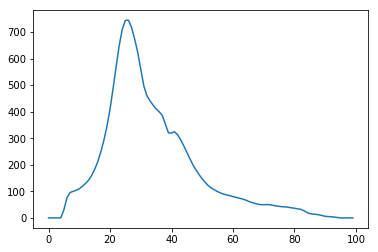

2020-09-23 14:52:45,265 - DEBUG - <ipython-input-25-d99f6bb9d01b>:calc_peak_and_intensity - Peak found at 26, with and intensity of 9629.63556539


26
(21, 31)
[487.4744981  571.29081726 649.8297716  711.10671535 744.03287598
 744.15447536 717.28606277 673.8265119  623.49164984 560.00945182]
('median ', 0.6731825712377031)


NameError: name 'save' is not defined

In [26]:
# Get all the azimuthally binned arrays to use and 
# the average array from all events
azav_use, ave_azav = det_azav(azav_data, i0_idxs)
peak, integrated_intensity, rad_start, rad_end = calc_peak_and_intensity(ave_azav, i0_data, np.median(i0_data))
p1 = azav_fig(ave_azav, peak, integrated_intensity, rad_start, rad_end)
show(p1)
# Questions
# Do we want to do any pre filtering of this data?  Say if the
# sum or the max of the array is below some predefined threshold

In [27]:
# Plot vs the intensity monitor value

def peak_in_bins(azav_use, peak, i_dat, range=RADIAL_RANGE, low_limit=PK_LOW):
    """Get the peak in the bins we're using"""
    low = peak - RADIAL_RANGE
    hi = peak + RADIAL_RANGE
    peak_vals = np.array([azav[low:hi].sum(axis=0) for azav in azav_use])
    peak_idxs = np.where(peak_vals > low_limit)
    peak_vals = peak_vals[peak_idxs]
    ratio = peak_vals.mean() / i_dat.mean()

    return peak_vals, peak_idxs, ratio

def fit_limits(intensity, peak_vals, i_low, i_high):
    m, b = np.polyfit(intensity, peak_vals, 1)
    x = np.arange(i_low, i_high, 0.1)
    sigma = np.std(peak_vals)
    y = x * m + b
    
    return x, y, m, b, sigma
    
def intensity_hist(intensity_hist, edges):
    fig = figure(
            title='Intensity Histogram'
    )
    fig.quad(top=intensity_hist, bottom=0, left=edges[:-1], right=edges[1:])
    
    return fig
    
def intensity_vs_peak_fig(intensity, peak_vals, x, y, ratio, slope, intercept, sigma):
    """Simple plot of intensity vs peak value"""
    mean = round(ratio, 2)
    fig = figure(
        title='Peak value vs Intensity.  Mean Value = {0}  Slope = {1}, Intercept = {2}'.format(round(ratio, 2), round(slope, 2), round(intercept, 2)),
        x_axis_label='Intensity Monitor Value',
        y_axis_label='Peak Values'
    )
    fig.x_range.range_padding = fig.y_range.range_padding = 0
    h, y_edge, x_edge = np.histogram2d(peak_vals, intensity, bins=100)
    fig.image(image=[h], x=x_edge[0], y=y_edge[0], dh=y_edge[-1]-y_edge[0], dw=x_edge[-1]-x_edge[0], palette="Spectral11")
    color_mapper = LinearColorMapper(palette="Spectral11", low=h.min(), high=h.max())
    color_bar = ColorBar(color_mapper=color_mapper, location=(0,0))
    fig.xaxis.bounds = [i0_low, i0_high]
    fig.add_layout(color_bar, 'right')
    fig.line(x, y, color='red')
    fig.line(x, y - 1 * sigma, color='orange')
    fig.line(x, y + 1 * sigma, color='orange')
    return fig

In [28]:
# Get the peak value for all azav arrays and plot vs intensity monitor value
peak_vals, peak_idxs, ratio = peak_in_bins(azav_use, peak, i0_data)
x, y, slope, intercept, sigma = fit_limits(i0_data[peak_idxs], peak_vals, i0_low, i0_high)
p2 = intensity_vs_peak_fig(i0_data[peak_idxs], peak_vals, x, y, ratio, slope, intercept, sigma)
show(p2)
# Questions
# How are we defining an acceptable lower value of intensity?
# Are we simply using the lower val on the intensity monitor, or should
# we fit the bottom of the population, look for the line fit and calculate
# the peak value we expect as a lower limit for intensity monitor value?

NameError: name 'save' is not defined

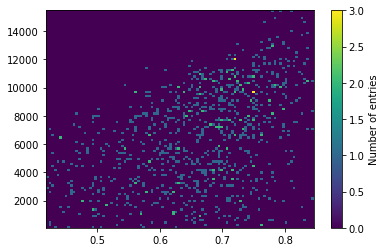

In [29]:
hist_intensity, edges_intensity = np.histogram(peak_vals, bins=100)
show(intensity_hist(hist_intensity, edges_intensity))
plt.hist2d(i0_data[peak_idxs], peak_vals, bins=100)
cb = plt.colorbar()
cb.set_label('Number of entries')
plt.show()
#plt.imshow((hist_intensity, hist))

In [30]:
results = {
    'low_slope': slope,
    'low_intercept': intercept,
    'low_i0': i0_low,
    'high_i0': i0_high,
    'ave_i0': i0_data.mean(),
    'ave_peak_intensity': integrated_intensity,
    'peak_bin': peak,
    'peak_lower_limit': rad_start,
    'peak_upper_limit': rad_end
}

#After processing
# Peak bin
# low and hi delta_r around peak bin
# Io low bound and high bound
# Average Io
# Average integrated intensity
# slope and intercept of fit of 2D plot
# sigma around line fit
# Run number

print(results)

{'low_intercept': -3719.9828800505975, 'ave_peak_intensity': 9629.635565387625, 'peak_upper_limit': 31, 'peak_lower_limit': 21, 'high_i0': 0.8466769609192851, 'ave_i0': 0.66258967352584, 'peak_bin': 26, 'low_slope': 15397.894228791347, 'low_i0': 0.41789974458224605}


In [31]:
gspec = pn.GridSpec(sizing_mode='stretch_both', max_height=1000)
gspec[0:3, 0:3] = p
gspec[4:6, 0:3] = p1
gspec[7:9, 0:3] = p2
gspec.save('report.html')